In [9]:
import numpy as np
import pandas as pd

import sys
import os

sys.path.append("/kaggle")
from src.utils.post_process import post_process_for_seg
from src.utils.metrics import event_detection_ap

In [2]:
keys = np.load("/kaggle/output/train/exp007/single/keys.npy")
labels = np.load("/kaggle/output/train/exp007/single/labels.npy")
preds = np.load("/kaggle/output/train/exp007/single/preds.npy")

In [5]:
val_pred_df, oof_df = post_process_for_seg(
    keys=keys,
    preds=preds[:, :, [1, 2]],
    score_th=0.02,
    distance=10,
    ret_oof_df=True,
)

In [8]:
labels = pd.read_csv("/kaggle/data/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(oof_df["series_id"].unique())]

In [12]:
score = event_detection_ap(labels, val_pred_df.to_pandas())
score

0.7462118623332705

616943

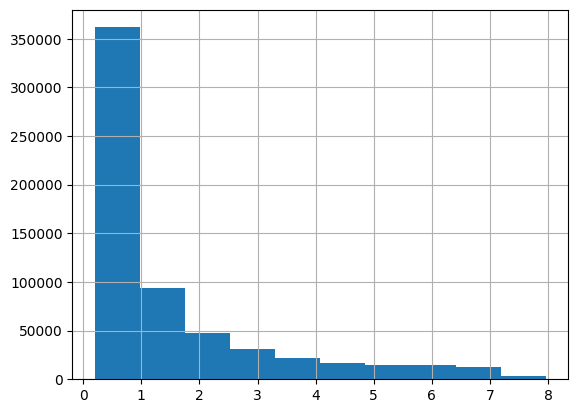

In [14]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.02]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.02]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"] *= 10
train["score"].hist()
len(train)

In [23]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import yaml
import matplotlib.pyplot as plt
import gc
from typing import Optional
from scipy.interpolate import interp1d


RANGE = 917
COEFF = 11
EXP = 5

def dynamic_range_nms(df: pd.DataFrame) -> pd.DataFrame:
    """Dynamic-Range NMS

    Parameters
    ----------
    df : pd.DataFrame
        単一のseries_idに対する提出形式
    """
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = []
    used_scores = []
    reduce_rate = np.ones(df["step"].max() + 1000)
    for _ in range(min(len(df), 1000)):
        df["reduced_score"] = df["score"] / reduce_rate[df["step"]]
        best_score = df["reduced_score"].max()
        best_idx = df["reduced_score"].idxmax()
        best_step = df.loc[best_idx, "step"]
        used.append(best_idx)
        used_scores.append(best_score)

        for r in range(1, int(RANGE)):
            reduce = ((RANGE - r) / RANGE) ** EXP * COEFF
            reduce_rate[best_step + r] += reduce
            if best_step - r >= 0:
                reduce_rate[best_step - r] += reduce
        reduce_rate[best_step] = 1e10
    df = df.iloc[used].copy()
    df["reduced_score"] = used_scores
    return df


In [25]:
from multiprocessing import Pool
import optuna

def objective(trial):
    global RANGE, COEFF, EXP
    RANGE = trial.suggest_int("RANGE", 100, 1000)
    COEFF = trial.suggest_int("COEFF", 1, 30)
    EXP = trial.suggest_int("EXP", 1, 10)        

    groups = [group for _, group in train.groupby("series_id")]
    with Pool(30) as p:  
        results = list(p.imap(dynamic_range_nms, groups))
    sub = pd.concat(results)
    sub["score"] = sub["reduced_score"]

    # スコア計算
    score = event_detection_ap(labels, sub)
    return score

study = optuna.create_study(direction="maximize")
study.enqueue_trial({"RANGE": 261, "COEFF": 28, "EXP": 5})
study.enqueue_trial({"RANGE": 917, "COEFF": 11, "EXP": 5})
study.enqueue_trial({"RANGE": 695, "COEFF": 14, "EXP": 3})
study.enqueue_trial({"RANGE": 360, "COEFF": 10, "EXP": 2})
study.enqueue_trial({"RANGE": 638, "COEFF": 17, "EXP": 3})
study.enqueue_trial({"RANGE": 570, "COEFF": 5, "EXP": 3})
study.optimize(objective, n_trials=60)
print(study.best_params)

[I 2023-11-04 13:45:08,659] A new study created in memory with name: no-name-6234646d-8d5f-4384-b601-a7d287a0fa62
[I 2023-11-04 13:45:14,113] Trial 0 finished with value: 0.7608372889214634 and parameters: {'RANGE': 261, 'COEFF': 28, 'EXP': 5}. Best is trial 0 with value: 0.7608372889214634.
[I 2023-11-04 13:45:20,615] Trial 1 finished with value: 0.7425796257336146 and parameters: {'RANGE': 917, 'COEFF': 11, 'EXP': 5}. Best is trial 0 with value: 0.7608372889214634.
[I 2023-11-04 13:45:26,959] Trial 2 finished with value: 0.7406614225190741 and parameters: {'RANGE': 695, 'COEFF': 14, 'EXP': 3}. Best is trial 0 with value: 0.7608372889214634.
[I 2023-11-04 13:45:32,511] Trial 3 finished with value: 0.7465012848805412 and parameters: {'RANGE': 360, 'COEFF': 10, 'EXP': 2}. Best is trial 0 with value: 0.7608372889214634.
[I 2023-11-04 13:45:38,647] Trial 4 finished with value: 0.7422401606419257 and parameters: {'RANGE': 638, 'COEFF': 17, 'EXP': 3}. Best is trial 0 with value: 0.760837288

{'RANGE': 293, 'COEFF': 29, 'EXP': 9}
